<a href="https://colab.research.google.com/github/jtlai0921/-/blob/master/keras_05_2transferlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [45]:
from glob import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import keras
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten
from keras.models import Model
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [46]:
IMG_SIZE = 100
class_map = {
    'PS':0,
    'Sc':1,
    'RS':2,
    'In':3,
    'Cr':4,
    'Pa':5
}

(200, 200, 3)


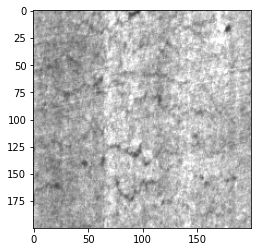

In [48]:
# Read single image
data_path = '/content/drive/MyDrive/緯育AI瑕疵檢測/Day2/NEU_defect/*.bmp' 
img_paths = glob(data_path)
img_paths = np.random.choice(img_paths, 300) # demo for 300 images
img = cv2.imread(img_paths[0])
plt.imshow(img)
print(img.shape)

In [ ]:
# Resize img
img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
plt.imshow(img_resized)
img.shape, img_resized.shape

In [ ]:
# Extract img class
img_path = img_paths[0]
img_path

In [ ]:
cls = img_path.split('/')[-1].split('_')[0]
cls

In [ ]:
class_map[cls]

# Method 1: Load Image and labels

In [ ]:
data_count = len(img_paths)
X = np.zeros((data_count, IMG_SIZE, IMG_SIZE, 3))
y = np.zeros((data_count, ))
print(data_count, X.shape, y.shape)

In [ ]:
for i, path in tqdm(enumerate(img_paths)):
    img = cv2.imread(path)
    img_resize = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    cls = path.split('/')[-1].split('_')[0]
    X[i] = img_resize
    y[i] = class_map[cls]

# Method2: load Images and labels from pickle file

In [51]:
import pickle
with open('/content/drive/MyDrive/緯育AI瑕疵檢測/Day2/y.pickle', 'rb') as file:
    X = pickle.load(file)
with open('/content/drive/MyDrive/緯育AI瑕疵檢測/Day2/y.pickle', 'rb') as file:
    y = pickle.load(file)
X.shape, y.shape

((1800, 1), (1800, 1))

In [52]:
# label count
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

{0.0: 300, 1.0: 300, 2.0: 300, 3.0: 300, 4.0: 300, 5.0: 300}

### Preprocessing

In [53]:
from keras.applications.inception_v3 import preprocess_input
X = preprocess_input(X) # preprocess images
y_onehot = keras.utils.to_categorical(y, num_classes=6) # one hot encoding

In [54]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=5566)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1440, 1), (360, 1), (1440, 6), (360, 6))

### Build Model

In [55]:
#Model 1: Use InceptionV3 as base model
base_model = keras.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)
model = Model(base_model.input, predictions)

In [56]:
# Model 2: InceptionV3 with freeze layers
base_model = keras.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)
model = Model(base_model.input, predictions)

# Freeze InceptionV3 layers
for layer in base_model.layers[:-10]:
    layer.trainable = False


In [57]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, 49, 49, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_282 (BatchN (None, 49, 49, 32)   96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 49, 49, 32)   0           batch_normalization_282[0][0]    
____________________________________________________________________________________________

In [58]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [59]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

checkpoint = ModelCheckpoint('drive/My Drive/ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
                             monitor='val_loss', 
                             save_weights_only=False)
# checkpoint2 = ModelCheckpoint('drive/My Drive/inceptionV3.h5',
#                               monitor='val_loss', 
#                               save_weights_only=False, 
#                               save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)


### Training

In [61]:
logs = model.fit(X_train, y_train,
                 batch_size=32,
                 epochs=100,
                 verbose=1,
                 callbacks=[early_stopping, reduce_lr],     
                 validation_data=(X_test, y_test))

Epoch 1/100


ValueError: ignored

In [ ]:
history = logs.history

In [ ]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.title('acc')

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
y_true = np.argmax(y_test, axis=-1)
y_pred = np.argmax(model.predict(X_test), axis=-1)
print(y_true.shape, y_pred.shape)
target_names = [str(i) for i in range(6)]
print(classification_report(y_true, y_pred, target_names=target_names))
print(confusion_matrix(y_true, y_pred))


In [ ]:
# Prediction